# ** IMPORT PACKAGES: **

In [6]:
# Python peripherals
import os
import random
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Scipy
import scipy.io
import scipy.stats as ss

# Numpy
import numpy

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.ticker as ticker

# PyTorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# IPython
from IPython.display import display, HTML

# Deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import CirclesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.training import DeepSignatureTupletsDataset
from deep_signature.nn.training import DeepSignatureNet
from deep_signature.nn.training import ContrastiveLoss
from deep_signature.nn.training import ModelTrainer


# ** HELPER FUNCTIONS: **

In [7]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# https://stackoverflow.com/questions/36074455/python-matplotlib-with-a-line-color-gradient-and-colorbar
def colorline(ax, x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = numpy.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = numpy.array([z])

    z = numpy.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    # ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = numpy.array([x, y]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plot_dist(ax, dist):
    x = numpy.array(range(dist.shape[0]))
    y = dist
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    colorline(ax=ax, x=x, y=y, cmap='hsv')

def plot_curve_sample(ax, curve, curve_sample, indices, zorder, point_size=10, alpha=1, cmap='hsv'):
    x = curve_sample[:, 0]
    y = curve_sample[:, 1]
    c = numpy.linspace(0.0, 1.0, curve.shape[0])

    ax.scatter(
        x=x,
        y=y,
        c=c[indices],
        s=point_size,
        cmap=cmap,
        alpha=alpha,
        norm=plt.Normalize(0.0, 1.0),
        zorder=zorder)

def plot_curve_section_center_point(ax, x, y, zorder, radius=1, color='white'):
    circle = plt.Circle((x, y), radius=radius, color=color, zorder=zorder)
    ax.add_artist(circle)

def plot_curve(ax, curve, linewidth=2, color='red', alpha=1):
    x = curve[:, 0]
    y = curve[:, 1]
    ax.plot(x, y, linewidth=linewidth, color=color, alpha=alpha)

def plot_curvature(ax, curvature, color='red', linewidth=2):
    x = range(curvature.shape[0])
    y = curvature
    ax.plot(x, y, color=color, linewidth=linewidth)

def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1):
    x = sample[:, 0]
    y = sample[:, 1]

    ax.scatter(
        x=x,
        y=y,
        s=point_size,
        color=color,
        alpha=alpha,
        zorder=zorder)

def all_subdirs_of(b='.'):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result

# ** GLOBAL SETTINGS: **

In [8]:
curves_dir_path_train = 'C:/deep-signature-data/circles/curves/train'
curves_dir_path_test = 'C:/deep-signature-data/circles/curves/test'
results_base_dir_path = 'C:/deep-signature-data/circles/results/tuplets'
plt.style.use("dark_background")

# ** SANITY CHECK - CURVES: **

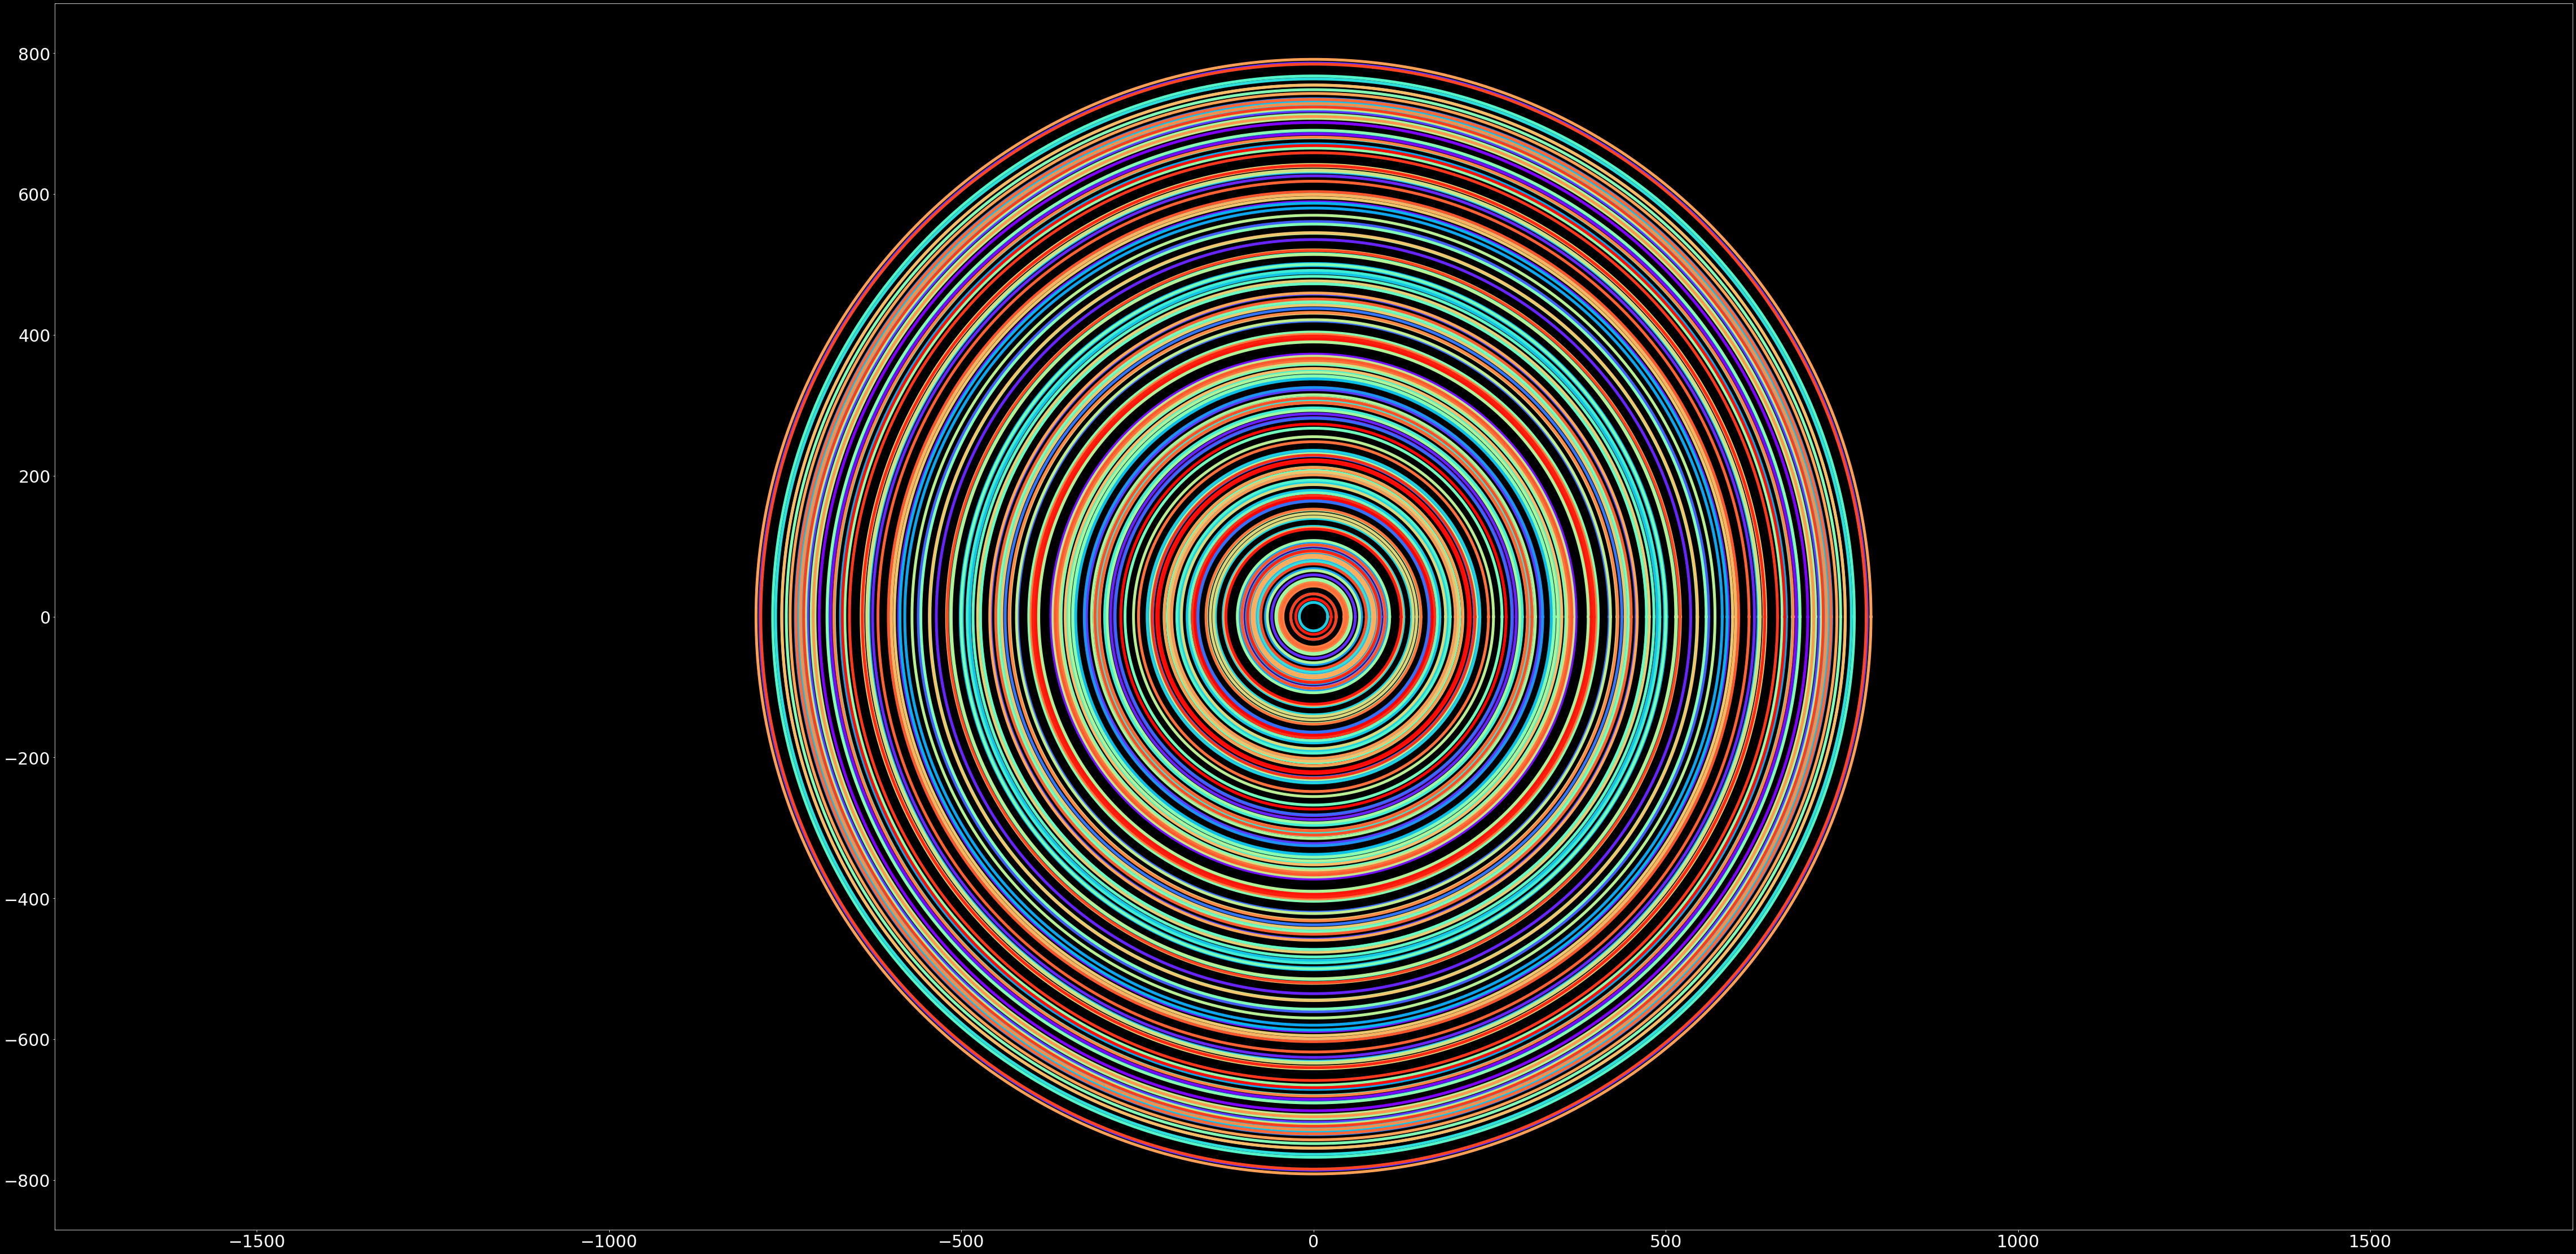

In [9]:
curves = CirclesGenerator.load_curves(dir_path=curves_dir_path_train)

fig, ax = plt.subplots(1, 1, figsize=(80,40))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
ax.axis('equal')

limit = 200
color_map = plt.get_cmap('rainbow', limit)

for i, curve in enumerate(curves[:limit]): 
    plot_curve(ax=ax, curve=curve, linewidth=5, color=color_map(i))

plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = SimpleDeepSignatureDataset()
dataset.load_dataset(
    negative_pairs_dir_path=negative_pairs_dir_path, 
    positive_pairs_dir_path=positive_pairs_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
# numpy.random.shuffle(indices)
sampler = SequentialSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random samples of positive and negative examples:</h3>'))
for pair_index, data in enumerate(data_loader, 0):
    if pair_index == 10:
        break

    curve1 = torch.squeeze(torch.squeeze(data['curves_channel1']))
    curve2 = torch.squeeze(torch.squeeze(data['curves_channel2']))
    label = int(torch.squeeze(data['labels']))

    if label == 1:
        pair_type = 'Positive'
    else:
        pair_type = 'Negative'

    display(HTML(f'<h3>{pair_type} sample #{pair_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.axis('equal')

    plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=50,
        color='lightcoral',
        zorder=50)

    plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=50,
        color='skyblue',
        zorder=50)

    plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAINING **

In [ ]:
torch.set_default_dtype(torch.float64)
dataset = SimpleDeepSignatureDataset()
dataset.load_dataset(
    negative_pairs_dir_path=negative_pairs_dir_path, 
    positive_pairs_dir_path=positive_pairs_dir_path)
model = SimpleDeepSignatureNet(layers=20, sample_points=sample_points).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = ContrastiveLoss(mu)
model_trainer = ModelTrainer(model=model, loss_fn=loss_fn, optimizer=optimizer)

print(model)

def epoch_handler(epoch_index):
    return

results = model_trainer.fit(dataset=dataset, epochs=epochs, batch_size=batch_size, results_base_dir_path=results_base_dir_path, epoch_handler=epoch_handler)

# ** TRAIN/VALIDATION LOSS **

In [ ]:
# results_file_path = os.path.normpath(os.path.join(results_base_dir_path, 'results.npy'))
all_subdirs = all_subdirs_of(results_base_dir_path)
latest_subdir = os.path.normpath(max(all_subdirs, key=os.path.getmtime))
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array']
validation_loss_array = results['validation_loss_array']
epochs_list = numpy.array(range(len(train_loss_array)))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=7.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=7.0)
plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

In [ ]:
torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureNet(layers=2, sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
model.eval()

limit = 50
curves = SimpleCurveDatasetGenerator.load_curves(dir_path=curves_dir_path_test)
numpy.random.seed(50)
numpy.random.shuffle(curves)
curves = curves[:limit]

color_map = plt.get_cmap('rainbow', limit)
fig, ax = plt.subplots(2, 1, figsize=(80,100))
ax[0].axis('equal')
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(30)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(30)

low = 0.1
high = 0.105
delta = numpy.random.uniform(low=low, high=high, size=[4000, 2])
for curve_index, curve in enumerate(curves): 
    plot_curve(ax=ax[0], curve=curve, color=color_map(curve_index), linewidth=5)
    predicted_curvature = numpy.zeros(curve.shape[0])
    center_index = 1
    for i in range(curve.shape[0]):
        current_delta = delta[i, :] * curve.shape[0]
        indices = numpy.array([i - int(current_delta[0]), i, i + int(current_delta[1])])
        indices = numpy.mod(indices, curve.shape[0])
        sample = curve[indices]
        center_point = sample[center_index]
        sample = sample - center_point

        if curve_processing.is_ccw(curve_sample=sample) is False:
            sample = numpy.flip(sample, axis=0)

        radians = curve_processing.calculate_tangent_angle(curve_sample=sample)
        sample = curve_processing.rotate_curve(curve=sample, radians=radians)
        batch_data = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample).double(), dim=0), dim=0).cuda()

        with torch.no_grad():
            predicted_curvature[i] = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()

    plot_curvature(ax=ax[1], curvature=predicted_curvature, color=color_map(curve_index), linewidth=5)
plt.show()